# Dynamic Time Warping

## Files and Data
#### ground-truth folder
Contains ground truth data.


#### transcription.txt  
- XXX-YY-ZZ: XXX = Document Number, YY = Line Number, ZZ = Word Number
- Contains the character-wise transcription of the word (letters seperated with dashes)
- Special characters denoted with s_
	- numbers (s_x)
	- punctuation (s_pt, s_cm, ...)
	- strong s (s_s)
	- hyphen (s_mi)
	- semicolon (s_sq)
	- apostrophe (s_qt)
	- colon (s_qo)
    
### Task
Three files:  
##### training and test data:
train.txt, valid.txt
both contain a list of documents
##### keywords that are at least once in the training and validation set defined by train.txt and valid.txt
keywords.txt

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
from dtaidistance import dtw
import cv2
import time
import os
import helpers
import pandas as pd
import math

In [2]:
###### IMPORTS
IMAGES = helpers.import_images()

In [3]:
###### OTHER VARIABLES
# files where keywords for validation are located
VALID_DOCUMENT_IDS = helpers.get_file('valid.txt')

# files where keywords for training are located
TRAIN_DOCUMENT_IDS = helpers.get_file('train.txt')

# list of words which are present in the training set and also in the valid set
KEYWORDS = helpers.get_file('keywords.txt')

# transcript with all infos about words
transcript_list = helpers.get_file('ground-truth/transcription.txt')
TRANSCRIPT = helpers.parse_transcript(transcript_list)

In [4]:
###### FEATURE EXTRACTION
# try loading first
try:
    IMAGES_REDUCED = helpers.load_obj("images_reduced")
except FileNotFoundError:
    print("File not found, calculating feature vectors...")
    IMAGES_REDUCED = helpers.features_and_labels(IMAGES,TRANSCRIPT)
    #IMAGES_REDUCED = helpers.reduce_to_feature_vectors(IMAGES)
    print("Done!")
    helpers.save_obj(IMAGES_REDUCED, "images_reduced")


print(IMAGES_REDUCED[:10])

[{'id': 0, 'document': '270', 'image': array([  0.,   0.,   0.,   0.,   0.,   0.,  19.,  10.,  34.,  37.,  48.,
        55.,  61.,  66.,  68.,  70.,  66.,  70.,  76.,  81.,  81.,  84.,
        83.,  85.,  86.,  90.,  92.,  97.,  96.,  97., 102.,  99.,  98.,
        98.,  98.,  94.,  97., 100., 100.,  99.,  98.,  94.,  92.,  89.,
        83.,  77.,  65.,  61.,  48.,  43.,  33.,  28.,  24.,  13.,  14.,
         0.,   0.,   0.,   0.,   0.,   0.,   8.,  16.,  17.,  31.,  33.,
        40.,  44.,  54.,  60.,  66.,  70.,  70.,  73.,  73.,  78.,  76.,
        73.,  72.,  70.,  67.,  60.,  59.,  63.,  64.,  66.,  69.,  65.,
        66.,  63.,  60.,  61.,  53.,  48.,  47.,  44.,  50.,  50.,  47.,
        50.,  62.,  65.,  71.,  77.,  78.,  79.,  80.,  80.,  80.,  77.,
        78.,  75.,  71.,  70.,  65.,  62.,  63.,  62.,  64.,  66.,  66.,
        65.,  69.,  66.,  67.,  70.,  68.,  72.,  68.,  72.,  72.,  69.,
        72.,  78.,  80.,  85.,  85.,  82.,  81.,  76.,  73.,  69.,  61.,
        52.,

### Evaluation

##### Feature Vectors
We used sliding window with 1px window width and 1px offset.  
Used vectors: 
1. number of black pixels per window

##### Questions (2)
*1. How many selected items are relevant?*  
*2. How many of the relevant are selected?*  
Precision = TP / TP + FP; Recall = TP / TP + FN  
WHERE TP: True positive, FP: False positive, FN: False negative


#### Steps
- iterate keywords
- for each keyword, find all other keywords
- for all other found keywords check if they are correct

In [5]:
#### SPLIT DATASET

data = pd.DataFrame(IMAGES_REDUCED)
train_set = data[data['document'].isin(TRAIN_DOCUMENT_IDS)]
valid_set = data[data['document'].isin(VALID_DOCUMENT_IDS)]

# create a keyword dictionary (with words as keys)
def create_keyword_dict(dataset, ids):
    keyword_dict = {}
    for i in range(len(data)):
        word = data.iloc[i]['word']
        document = data.iloc[i]['document']
        if word not in keyword_dict and document in ids:
            keyword_dict[word] = i
    return keyword_dict

keyword_dict_train = create_keyword_dict(train_set, TRAIN_DOCUMENT_IDS)
keyword_dict_valid = create_keyword_dict(valid_set, VALID_DOCUMENT_IDS)

In [11]:
###### GET DISTANCE MATRIX
        
# compute the matrix with all distances of words to each other
def compute_distance_matrix(data_set):
    # define list of feature vectors to be compared
    vectors = [np.array(x) for x in data_set['image']]

    # compute and save distance matrix
    # the function returns an upper triangular matrix with inf filled in. produce a symmetric matrix
    triangular_matrix = dtw.distance_matrix_fast(vectors)
    distance_matrix = np.triu(triangular_matrix) + np.triu(triangular_matrix).T
    np.fill_diagonal(distance_matrix, 0)
    np.matrix(distance_matrix)
    return distance_matrix

# try to load the matrix for train data
try:
    distance_matrix_train = np.load("distance_matrix_train.dat", allow_pickle=True)
except FileNotFoundError:
        print("Couldn't find stored train matrix, calculating...")
        distance_matrix_train = compute_distance_matrix(train_set)
        distance_matrix_train.dump("distance_matrix_train.dat")
        
# try to load the matrix for valid data
try:
    distance_matrix_valid = np.load("distance_matrix_valid.dat", allow_pickle=True)
except FileNotFoundError:
        print("Couldn't find stored valid matrix, calculating...")
        distance_matrix_valid = compute_distance_matrix(valid_set)
        distance_matrix_valid.dump("distance_matrix_valid.dat")

Couldn't find stored train matrix, calculating...
(2958528, 2958528)
Couldn't find stored valid matrix, calculating...
(835278, 835278)


In [8]:
print(keyword_dict_valid)

{'s_3-s_0-s_0-s_pt': 2433, 'L-e-t-t-e-r-s-s_cm': 2434, 'O-r-d-e-r-s': 2435, 'a-n-d': 2436, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt': 2437, 'D-e-c-e-m-b-e-r': 2438, 's_1-s_7-s_5-s_5-s_pt': 2439, 'H-o-g-g-s_qt-s': 2440, 'C-o-m-p-a-n-y-s_cm': 2441, 'i-f': 2442, 'a-n-y': 2443, 'o-p-p-o-r-t-u-n-i-t-y': 2444, 'o-f-f-e-r-s-s_pt': 2445, 'Y-o-u': 2446, 'a-r-e': 2447, 't-o': 2448, 'b-e': 2449, 'p-a-r-t-i-c-u-l-a-r-l-y': 2450, 'e-x-s_mi': 2451, 'a-c-t': 2452, 'c-a-r-e-f-u-l': 2454, 'i-n': 2455, 't-h-e-s-e': 2456, 'p-a-y-m-e-n-t-s-s_qo': 2457, 's-e-e-s_mi': 2458, 'i-n-g': 2459, 't-h-a-t': 2460, 't-h-e-r-e': 2461, 'i-s': 2462, 'n-o': 2463, 'd-i-s-a-g-r-e-e-m-e-n-t': 2464, 'b-e-t-w-e-e-n': 2465, 't-h-e': 2466, 'R-e-t-u-r-n-s-s_cm': 2467, 'y-o-u-r': 2469, 'P-a-y-s_mi-R-o-l-l-s-s_sq': 2470, 'a-s': 2471, 'w-i-l-l': 2473, 's-t-r-i-c-t': 2475, 'e-x-a-m-i-n-a-t-i-o-n': 2476, 'i-n-t-o': 2477, 'i-t': 2478, 'h-e-r-e-a-f-s_mi': 2479, 't-e-r-s_pt': 2480, 'I': 2481, 'a-m': 2482, 's_et-c-s_pt': 2483, 's_GW': 2484, 'A-l-e-

In [20]:
###### GET EVALUATION DATA
# Iterate through keywords and using the distance matix
# Determine tp, fp, fn for different numbers of the top k images with smalles distance to the keyword
# With this precision and recall can be plotted against each other for different.

'''
step: number of number of words added as 'accepted' for each eval point
      e.g. first the top 10 words are accepted, then the top 20, etc. and then evaluate accordingly
length: number of data points
nr_of_eval_point: number of data points for the precision-recall curve
'''

def get_evaluation_data(dataset, keyword_dict, distance_matrix):
    # define desired step size for plot
    step = 1
    length = len(dataset)
    nr_of_eval_points = math.ceil(length/float(step))

    tp_array = np.zeros(nr_of_eval_points)
    fp_array = np.zeros(nr_of_eval_points)
    fn_array = np.zeros(nr_of_eval_points)

    # supress warnings
    pd.options.mode.chained_assignment = None

    start = time.time()

    for keyword, index in keyword_dict.items():
        results = dataset[['image','word']]
        results['distance'] = distance_matrix[:,index -2433]
        results = results.sort_values('distance')

        if index % 20 == 0:
            print('Current Keyword ({}/{}): {}'.format(index, len(results), keyword))
    
        # list of words ordered by distance to keyword
        selectable = results['word'].tolist()
    
        for i in range(1,nr_of_eval_points):
        
            nr_words = i*step
            selected = selectable[:nr_words]
            not_selected = selectable[nr_words:]
        
            # TODO neglect upper/lowercase, special characters
            tp = selected.count(keyword)      #true positives
            fp = nr_words - tp                #fales positives
            fn = not_selected.count(keyword)  #false negatives

            tp_array[i] += tp
            fp_array[i] += fp
            fn_array[i] += fn
        
            #if i<5: 
                #print('Results (tp:{}, fp:{}, total: {}):'.format(tp, fp, nr_words))
                #print(selected)
            
    
    
        # TODO remove, just for debugging purposes
        #f index>1: break
    print("total time: " + str(time.time() - start))
    return tp_array, fp_array, fn_array

In [13]:
train_results = get_evaluation_data(train_set, keyword_dict_train, distance_matrix_train)

Current Keyword (0/2433): s_2-s_7-s_0-s_pt
Current Keyword (20/2433): a-r-e
Current Keyword (160/2433): O-f-f-i-c-e-r
Current Keyword (180/2433): S-e-r-g-e-a-n-t-s_cm
Current Keyword (200/2433): r-e-l-i-e-v-e-d
Current Keyword (220/2433): C-a-m-p-s_pt
Current Keyword (240/2433): o-r-d-e-r-e-d
Current Keyword (260/2433): S-u-r-g-e-o-n-s_cm
Current Keyword (280/2433): s_et-c-s_pt
Current Keyword (300/2433): D-e-l-a-y-s
Current Keyword (340/2433): j-o-i-n-s-s_cm
Current Keyword (360/2433): M-e-n-s_pt
Current Keyword (440/2433): d-i-s-p-l-e-a-s-e-d
Current Keyword (520/2433): i-n-c-l-o-s-i-n-g
Current Keyword (600/2433): o-t-h-e-r-s-s_cm
Current Keyword (640/2433): m-o-s-t
Current Keyword (680/2433): o-w-n
Current Keyword (760/2433): p-r-o-v-i-s-i-o-n-s
Current Keyword (800/2433): C-r-e-e-k-s_cm
Current Keyword (920/2433): g-o-n-s-s_cm
Current Keyword (960/2433): p-a-i-r
Current Keyword (1080/2433): H-o-r-s-e-s-s_cm
Current Keyword (1100/2433): h-o-r-s-e-s
Current Keyword (1120/2433): m-i-

In [19]:
keyword_dict_valid.values()


dict_values([2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2469, 2470, 2471, 2473, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2487, 2489, 2490, 2492, 2493, 2494, 2495, 2496, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2510, 2511, 2513, 2516, 2517, 2518, 2520, 2521, 2523, 2524, 2525, 2528, 2530, 2532, 2534, 2535, 2536, 2537, 2540, 2541, 2542, 2543, 2544, 2546, 2547, 2548, 2549, 2552, 2554, 2555, 2556, 2557, 2559, 2561, 2562, 2564, 2567, 2569, 2570, 2571, 2573, 2574, 2575, 2577, 2579, 2581, 2582, 2583, 2586, 2588, 2589, 2592, 2594, 2597, 2598, 2600, 2602, 2603, 2604, 2607, 2608, 2609, 2612, 2613, 2614, 2618, 2621, 2623, 2625, 2626, 2627, 2629, 2630, 2635, 2642, 2643, 2645, 2646, 2647, 2649, 2651, 2653, 2654, 2656, 2659, 2660, 2661, 2664, 2666, 2667, 2668, 2669, 2672, 2676, 2679, 2680, 2683, 268

In [21]:
valid_results = get_evaluation_data(valid_set, keyword_dict_valid, distance_matrix_valid)

Current Keyword (2440/1293): H-o-g-g-s_qt-s
Current Keyword (2460/1293): t-h-a-t
Current Keyword (2480/1293): t-e-r-s_pt
Current Keyword (2520/1293): b-a-l-a-n-c-e
Current Keyword (2540/1293): r-e-t-u-r-n-e-d
Current Keyword (2600/1293): o-r-d-e-r
Current Keyword (2660/1293): n-e-v-e-r
Current Keyword (2680/1293): R-e-g-i-m-e-n-t-s_cm
Current Keyword (2700/1293): d-e-a-d-s_cm
Current Keyword (2740/1293): a-n
Current Keyword (2760/1293): k-i-n-d
Current Keyword (2780/1293): u-n-t-i-l
Current Keyword (2820/1293): n-e-a-r
Current Keyword (2880/1293): B-l-a-n-k
Current Keyword (2900/1293): t-h-i-n-g-s
Current Keyword (3060/1293): Y-e-s-t-e-r-d-a-y
Current Keyword (3100/1293): B-o-r-d-e-r-s
Current Keyword (3120/1293): a-b-o-u-t
Current Keyword (3200/1293): n-e-c-e-s_s-s_mi
Current Keyword (3280/1293): a-i-d
Current Keyword (3320/1293): t-h-e-i-r-s
Current Keyword (3340/1293): C-h-e-s_mi
Current Keyword (3400/1293): C-h-u-r-c-h-s_cm
Current Keyword (3420/1293): g-e-n-e-s_mi
Current Keyword 

In [25]:
tp_train, fp_train, fn_train = train_results
tp_valid, fp_valid, fn_valid = valid_results

/home/skatinger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/skatinger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/skatinger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/skatinger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


<function matplotlib.pyplot.show(*args, **kw)>

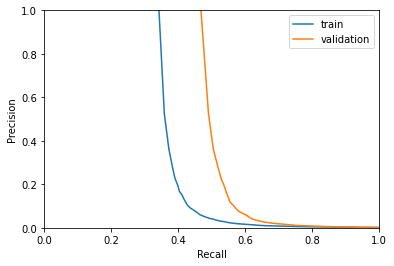

In [27]:
#print('TP:',tp_array)
#print('FP:',fp_array)
#print('FN:',fn_array)
precision_train = np.divide(tp_train,np.add(tp_train,fp_train))
recall_train = np.divide(tp_train,np.add(tp_train,fn_train))

precision_valid = np.divide(tp_valid,np.add(tp_valid,fp_valid))
recall_valid = np.divide(tp_valid,np.add(tp_valid,fn_valid))
#print('Precision:',precision)
#print('Recall:',recall)

# precision: TP / TP + FP
# recall: TP / TP + FN

plt.plot(recall_train,precision_train)
plt.plot(recall_valid,precision_valid)
plt.legend(['train', 'validation'], loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show